# Real leakage of a single bit

This example is similar to example 1, but the data is drawn from power measurements of AES encryption on ATmega. We look at a single bit of the 1 round S-box output and buid a model for the leakage using linear regression (with OLS). A more elaborate OLS implementation is used, namely the one which is suitable for multivariate OLS (useful for the third example). Aditionaly, we plot histograms to describe the leakage in the Gaussian model, i.e. we build templates.

This illustrates two ways leakage (signal) can be modelled from real data (so called profiling):
* linear regression provides a formula for predicting the signal from the intermediate value
* templates provide exact values for the signal for each value of the intermediate (think of leakage function defined by a table with values)

The noise is modelled in the same way in both cases, but here we will not deal with noise becasue we will used the leakge model only in the correaltion distinguisher that does not make use of noise.

Part of the leakage modeling tutorial, license is GPLv3, see https://www.gnu.org/licenses/gpl-3.0.en.html<br>
Requires traces and data from [pysca toolbox](https://github.com/ikizhvatov/pysca)

In [3]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

We need AES S-box to compute the output bit value

In [4]:
''' initially defined explcitly...
sbox = np.array([
0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16], dtype='uint8')
'''
# ...but we pre-saved it to the numpy daa file and just load it
sbox = np.load('../data/aessbox.npy')

Parameter: bit of the S-Box output to work with

In [2]:
bit = 0

Load samples and data. From the trace of many samples, we take a single sample 1025 that leaks (I know it from an earlier DPA). You can take other samples and see what happens.

In [7]:
npzfile = np.load('../traces/swaes_atmega_power.npz')
data = npzfile['data'][:,0]
traces = npzfile['traces'][:,1025]

At this point we have a set of 1-sample traces and a corresponding set of 1-byte S-box inputs.

Now, knowing the key byte, we compute the intermediate variable values - S-box outputs.

In [8]:
keyByte = np.uint8(0x2B)
sBoxOut = sbox[data ^ keyByte]

Now, we are interested in this example in a single bit of the intermediate variable

In [9]:
sBoxOutBit = (sBoxOut >> bit) & 1

Perform regression, i.e. solve the system using OLS, and print the results. This function provides an extended report; we are mainly interested in coefficient x1 (and constant coefficient). 

In [13]:
A = sm.add_constant(sBoxOutBit, prepend=False) # add constant coefficient (trailing column of ones)
results = sm.OLS(traces, A).fit() # the OLS itself
beta = results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     368.3
Date:                Fri, 16 Jun 2017   Prob (F-statistic):           1.79e-75
Time:                        10:17:30   Log-Likelihood:                -6824.7
No. Observations:                2000   AIC:                         1.365e+04
Df Residuals:                    1998   BIC:                         1.366e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.3035      0.328     19.191      0.0

Visualize the regression and the modelled Gaussian distribution (templates)

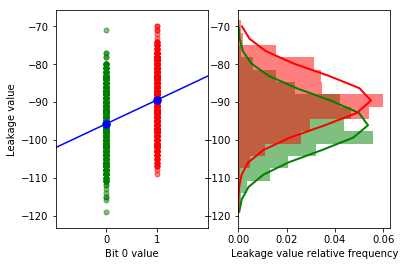

In [17]:
# initial data (as dots) and the fitted line
fig = plt.figure()
ax1 = fig.add_subplot(121)
xnew = np.array([-2, 0, 1, 3]) # to plot a line with dots in the right places
line = beta[0] * xnew + beta[1] # regression line
samples0 = traces[np.nonzero(sBoxOutBit == 0)[0]]
samples1 = traces[np.nonzero(sBoxOutBit == 1)[0]]
plt.plot(np.zeros(len(samples0)), samples0, 'g.', alpha=0.5, markersize=10)
plt.plot(np.ones(len(samples1)), samples1, 'r.', alpha=0.5, markersize=10)
plt.plot(xnew, line, 'b.-', markersize=15)
plt.xlim((-1, 2))
plt.xticks([0,1])
ax1.set_xlabel("Bit %d value" % bit)
plt.ylabel("Leakage value")

# for more comprehension, plot histograms for leakage of 0 and 1
ax2 = fig.add_subplot(122, sharey=ax1)
numBins = 16.0
binSize = (max(traces) - min(traces)) / float(numBins - 1);
binEdges = np.arange(min(traces) - (binSize / 2.0), max(traces) + (binSize / 2.0) + 1, binSize)
plt.hist(samples0, bins=binEdges, normed=1, facecolor='green', alpha=0.5, orientation='horizontal')
plt.hist(samples1, bins=binEdges, normed=1, facecolor='red', alpha=0.5, orientation='horizontal')
ax2.set_xlabel("Leakage value relative frequency")

# estimate mu and sigma, and plot the normal curves
binCenters = 0.5*(binEdges[1:]+binEdges[:-1])
normPdf0 = mlab.normpdf(binCenters, np.mean(samples0), np.sqrt(np.var(samples0)))
normPdf1 = mlab.normpdf(binCenters, np.mean(samples1), np.sqrt(np.var(samples1)))
plt.plot(normPdf0, binCenters, 'g-', linewidth=2)
plt.plot(normPdf1, binCenters, 'r-', linewidth=2)
plt.show()